In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from Higgs.tools import ImplementationUtils as impl

## LHC13 `pp -> H+- tb` cross sections

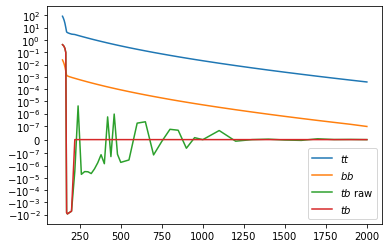

In [2]:
dfHpmtb = impl.read_csv_from_web(
    "https://gitlab.com/higgsbounds/higgsbounds/-/raw/master/data/Theory_tables/ChargedHiggs_Cxns/LHC13_coefficients.dat",
    sep=r"\s+",
).set_index("mHc")

ir = impl.relevantGridEntries(
    dfHpmtb.index,
    dfHpmtb.values,
)
dfHpmtb = dfHpmtb.iloc[ir]
# interference just fluctuates around 0 within theoretical uncertainty for
# masses above 200GeV both relative to the others and absolute
assert np.allclose((dfHpmtb.x_tb / (dfHpmtb.x_tt + dfHpmtb.x_bb)).loc[220:], 0, atol=1e-5)
assert np.allclose(dfHpmtb.loc[220:, "x_tb"], 0, atol=1e-5)

plt.figure()
plt.plot(dfHpmtb.index, dfHpmtb.x_tt, label=r"$tt$")
plt.plot(dfHpmtb.index, dfHpmtb.x_bb, label=r"$bb$")
plt.plot(dfHpmtb.index, dfHpmtb.x_tb, label=r"$tb$ raw")
dfHpmtb.loc[220:, "x_tb"] = 0 # so zero it out for simplicity
plt.plot(dfHpmtb.index, dfHpmtb.x_tb, label=r"$tb$")
plt.yscale("symlog", linthresh=1e-7)
plt.legend()
plt.show()



## `pp -> Hpm H/A`

LO * NNLO K-factor cxn from the charged Higgs benchmarks paper [2103.07484](https://arxiv.org/abs/2103.07484)


Text(0, 0.5, '$m_\\phi$ [GeV]')

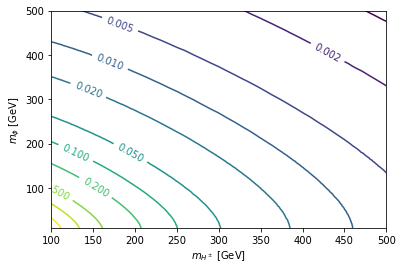

In [3]:
dfHpmPhi = (
    pd.read_table(
        "https://arxiv.org/src/2103.07484v3/anc/cxn_HpmPhi.tsv.xz",
        sep="\t",
        compression="xz",
    )
    .set_index(["mPhi", "mHp"])
    .sort_index()
)

plt.figure()
CS = plt.contour(
    dfHpmPhi.index.levels[1],
    dfHpmPhi.index.levels[0],
    dfHpmPhi.cxn_NNLO.values.reshape([len(x) for x in dfHpmPhi.index.levels]),
    levels=[1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2],
    norm=mcol.LogNorm(1e-3, 2),
)
plt.clabel(CS, inline=True)
plt.xlabel(r"$m_{H^\pm}$ [GeV]")
plt.ylabel(r"$m_\phi$ [GeV]")

## Export to C++ file

In [4]:
from helpers import *

with cppDataFile(
    "../src/predictions/data/HpmTables.cpp", scriptname="tools/transferHpmCxns.ipynb"
) as cppf:
    cppf.write("const auto gridHpmtb = ")
    cppf.write(grid2CppString([dfHpmtb.index.values]))
    cppf.write("const auto lhc13Hpmtb = ")
    cppf.write(values2CppString(dfHpmtb.values))

    cppf.write("const auto gridHpmPhi = ")
    cppf.write(grid2CppString(dfHpmPhi.index.levels))
    cppf.write("const auto lhc13HpmPhi = ")
    cppf.write(values2CppString(dfHpmPhi.cxn_NNLO.values))


